In [222]:
import numpy as np
import pandas as pd
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preparing the dataframe

In [57]:
df = pd.read_csv('/content/drive/MyDrive/liders_hack/pet-search/meta/result')
df.head()

,directopy,filename,is_animal_there,is_it_a_dog,is_the_owner_there,color,tail,address,cam_id
0,Датасет/Пустые/,6366.jpg,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,Датасет/Пустые/,348.jpg,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,Датасет/Пустые/,360.jpg,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Датасет/Пустые/,228.jpg,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Датасет/Пустые/,566.jpg,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [59]:
def find_sr_img(img):
    base_path_0 = '/content/drive/MyDrive/liders_hack/datasets/super_res/0'
    base_path_1 = '/content/drive/MyDrive/liders_hack/datasets/super_res/1'
    sr_img = sr_img_name(img)
    for name in [sr_img, change_ext(sr_img)]:
        if os.path.isfile(os.path.join(base_path_0, name)):
            return os.path.join(base_path_0, name)
        elif os.path.isfile(os.path.join(base_path_1, name)):
            return os.path.join(base_path_1, name)
    print(f'{img} not found')
    return np.nan

def find_mask(img):
    base_path = '/content/drive/MyDrive/liders_hack/datasets/super_res/dog_masks'
    name, _ = img.split('.')
    name += '_out.pkl'
    path = os.path.join(base_path, name)
    if not os.path.isfile(path):
        # print(f'{img} path not found')
        return np.nan
    return path


def sr_img_name(name):
    img, ext = name.split('.')
    img += '_out'
    return '.'.join([img, ext])

def change_ext(name):
    img, ext = name.split('.')
    if ext == 'png':
        new_ext = 'jpg'
    elif ext == 'jpg':
        new_ext = 'png'
    return '.'.join([img, new_ext])

In [66]:
dogs = df.drop(df[df.is_it_a_dog == 0].index)
dogs['img_path'] = dogs.filename.apply(find_sr_img)
dogs['dog_mask'] = dogs.filename.apply(find_mask)

398.png not found
600.jpg not found
706.jpg not found
300.png not found
620.jpg not found


In [75]:
data = pd.concat([dogs.img_path, dogs.dog_mask, dogs.color], join='inner', axis=1)
data = data.dropna()
print(len(data))
data.head(3)

1566


,img_path,dog_mask,color
324,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0
325,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0
326,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0


### Preparing the datset

In [116]:
def get_color_features(img, mask):
    '''
    img: PIL image with shape (C x H x W)
    masks: dog mask with shape (1 x H x W)
    Returns: numpy arrays of color features
    '''
    mask = mask.astype(bool)
    average_color = np.zeros(3)
    color_std = np.zeros(3)
    masked_img = img[mask].reshape(3, -1)
    average_color = np.mean(masked_img, axis=1)
    color_std = np.std(masked_img, axis=1)
    features = np.concatenate([average_color, color_std], axis=0)
    return features


In [135]:
features = np.zeros((6, len(data)), dtype=float)
for i, (_, row) in tqdm(enumerate(data.iterrows())):
    img = Image.open(row.img_path)
    img = np.asarray(img.convert('RGB'))
    img = np.rollaxis(img, axis=-1)
    with open(row.dog_mask, 'rb') as f:
        mask_data = pickle.load(f)
    if len(mask_data[1][0]) == 0:
        features[:, i] = 0
        continue
    mask = mask_data[1][0][0][np.newaxis, :, :].repeat(3, axis=0)
    features[:, i] = get_color_features(img, mask)
    

1566it [25:32,  1.02it/s]


AttributeError: ignored

In [140]:
features_dict = {
    'mean_R': features[0],
    'mean_G': features[1],
    'mean_B': features[2],
    'std_R': features[3],
    'std_G': features[4],
    'std_B': features[5],
}
data = data.append(features_dict, ignore_index=False)

TypeError: ignored

In [139]:
data

,img_path,dog_mask,color,mean_B,mean_G,mean_R,std_B,std_G,std_R
0,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,/content/drive/MyDrive/liders_hack/datasets/su...,/content/drive/MyDrive/liders_hack/datasets/su...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1567,NaN,NaN,NaN,"[134.65756733905062, 176.1317343961284, 0.0, 0...","[150.93163425534485, 172.46295637321188, 0.0, ...","[149.34629786206062, 175.85211017009465, 0.0, ...","[76.97195901196838, 39.67409144651971, 0.0, 0....","[75.01837058501825, 38.76108501494758, 0.0, 0....","[75.23482757734614, 34.26355532853501, 0.0, 0...."
1568,NaN,NaN,NaN,"[134.65756733905062, 176.1317343961284, 0.0, 0...","[150.93163425534485, 172.46295637321188, 0.0, ...","[149.34629786206062, 175.85211017009465, 0.0, ...","[76.97195901196838, 39.67409144651971, 0.0, 0....","[75.01837058501825, 38.76108501494758, 0.0, 0....","[75.23482757734614, 34.26355532853501, 0.0, 0...."
1569,NaN,NaN,NaN,"[134.65756733905062, 176.1317343961284, 0.0, 0...","[150.93163425534485, 172.46295637321188, 0.0, ...","[149.34629786206062, 175.85211017009465, 0.0, ...","[76.97195901196838, 39.67409144651971, 0.0, 0....","[75.01837058501825, 38.76108501494758, 0.0, 0....","[75.23482757734614, 34.26355532853501, 0.0, 0...."
1570,NaN,NaN,NaN,"[134.65756733905062, 176.1317343961284, 0.0, 0...","[150.93163425534485, 172.46295637321188, 0.0, ...","[149.34629786206062, 175.85211017009465, 0.0, ...","[76.97195901196838, 39.67409144651971, 0.0, 0....","[75.01837058501825, 38.76108501494758, 0.0, 0....","[75.23482757734614, 34.26355532853501, 0.0, 0...."


In [182]:
new_data = data.drop(data[data.mean_R == 0.0].index)
new_data

ValueError: ignored

In [203]:
X = features.T
y = data['color'][:-1]

In [204]:
X_new = X[data.color.notnull()[:-1], :]
y_new = y[data.color.notnull()[:-1]]

In [205]:
non_zero_idx = np.argwhere(X_new[:, 0] != 0)

In [206]:
X_new = X_new[non_zero_idx].squeeze()
y_new = y_new[non_zero_idx.squeeze()]
X_new.shape, y_new.shape

((1073, 6), (1073,))

In [193]:
zero_idx

array([[   0],
       [   1],
       [   2],
       ...,
       [1562],
       [1563],
       [1564]])

In [221]:
clf = SGDClassifier()
scores = cross_val_score(clf, X_new, y_new, cv=5, scoring='balanced_accuracy')
print(f'SGD: {scores.mean()}, {scores.std()}')

SGD: 0.4363777821476674, 0.04328061977119254


In [208]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_new, y_new, cv=5, scoring='balanced_accuracy')
print(f'RF: {scores.mean()}, {scores.std()}')

RF: 0.4674267830538641, 0.0499631657433


In [239]:
clf = MLPClassifier((100))
scores = cross_val_score(clf, X_new, y_new, cv=5, scoring='balanced_accuracy')
print(f'MLP: {scores.mean()}, {scores.std()}')

MLP: 0.4793990942477809, 0.043703090018551834


In [245]:
clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
scores = cross_val_score(clf, X_new, y_new, cv=5, scoring='balanced_accuracy')
print(f'KNN: {scores.mean()}, {scores.std()}')

KNN: 0.4786040691079537, 0.06231944765942728


In [210]:
tsne = TSNE()
X_embed = tsne.fit_transform(X_new)

In [180]:
X_embed.shape

(1566, 2)

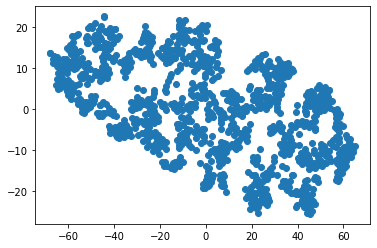

In [211]:
plt.scatter(X_embed[:, 0], X_embed[:, 1])